In [1]:
import numpy as np
import cvxpy as cp
import pandas as pd
import matplotlib.pyplot as plt
import random
from joblib import Parallel, delayed
from multiprocessing import cpu_count

## CPS Data

In [2]:
df = pd.read_csv('CPS.csv',sep=';')
Y_true_full = np.reshape(df['log_wage'].values, (40,-1))
Y_true_full = Y_true_full.T
Y_true_full /= np.std(Y_true_full)
Y_true_full -= np.mean(Y_true_full)
N_total,T_total = Y_true_full.shape

min_wage = np.reshape(df['min_wage'].values, (40,-1))
min_wage = min_wage.T

In [3]:
df

,state,year,log_wage,hours,urate,min_wage,open_carry,abort_ban
0,AK,1979,-0.759183,37.504,0.073,False,False,False
1,AL,1979,-2.269627,36.289,0.065,False,False,False
2,AR,1979,-2.225654,37.182,0.060,False,False,False
3,AZ,1979,-1.724803,38.692,0.045,False,False,False
4,CA,1979,-1.651739,36.578,0.060,False,False,False
...,...,...,...,...,...,...,...,...
1995,VT,2018,1.676063,38.760,0.027,True,True,True
1996,WA,2018,1.702448,36.485,0.033,True,False,True
1997,WI,2018,1.311645,35.916,0.009,False,True,False
1998,WV,2018,1.264739,36.563,0.055,False,True,False


In [4]:
Y_true_full.shape

(50, 40)

## Replicate SDID Table

In [5]:
np.argwhere(min_wage==True)

array([[ 4, 39],
       [ 6, 39],
       [ 7, 39],
       [18, 39],
       [36, 39],
       [38, 39],
       [45, 39],
       [46, 39]])

In [6]:
Ds = np.argwhere(min_wage==True)[:,0]
Ds

array([ 4,  6,  7, 18, 36, 38, 45, 46])

In [7]:
assignment_vector = np.zeros((N_total,))
assignment_vector[Ds] = 1

In [8]:
assignment_vector

array([0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.])

In [9]:
W_true_full=np.zeros(Y_true_full.shape)
#W_true_full[assignment_vector,-10:]=0

### Fit rank 4 factor model

In [10]:
def decompose_Y(Y,rank=4):
    N, T = Y.shape

    u,s,v = np.linalg.svd(Y)
    factor_unit = u[:,:rank]
    factor_time = v[:rank,:]
    L = np.dot(factor_unit*s[:rank],factor_time)
    E = Y - L
    F = np.add.outer(np.mean(L,axis=1),np.mean(L,axis=0)) - np.mean(L)
    M = L-F
    
    return F, M, E, factor_unit*np.sqrt(N)

In [11]:
def decompose_Y_nuclear(Y,lambda_nn=0.8):
    L=run_MCNNM(np.multiply(Y,1-W_true_full),np.argwhere(1-W_true_full), lambd=lambda_nn, threshold = 1e-5, print_every= None, max_iters = 20000)
    E = Y_true_full - L
    F = np.add.outer(np.mean(L,axis=1),np.mean(L,axis=0)) - np.mean(L)
    M = L-F
    u,s,v = np.linalg.svd(Y)
    factor_unit = u[:,:4]
    return F, M, E, factor_unit*np.sqrt(N_total)

### Fit AR(2) model

In [12]:
def fit_ar2(E):
    
    T_full = E.shape[1]
    E_ts = E[:, 2:]
    E_lag_1 = E[:, 1:-1]
    E_lag_2 = E[:,:-2]
    
    a_1 = np.sum(np.diag(np.matmul(E_lag_1, E_lag_1.T)))
    a_2 = np.sum(np.diag(np.matmul(E_lag_2, E_lag_2.T)))
    a_3 = np.sum(np.diag(np.matmul(E_lag_1, E_lag_2.T)))
    
    matrix_factor = np.array([[a_1, a_3], 
                         [a_3, a_2]])
    
    b_1 = np.sum(np.diag(np.matmul(E_lag_1, E_ts.T)))
    b_2 = np.sum(np.diag(np.matmul(E_lag_2, E_ts.T)))
    
    ar_coef = np.linalg.inv(matrix_factor).dot(np.array([b_1, b_2]))

    return ar_coef

### Correlation matrix

In [13]:
def ar2_correlation_matrix(ar_coef, T):
    
    result = np.zeros(T)
    result[0] = 1
    result[1] = ar_coef[0] / (1 - ar_coef[1])
    for t in range(2, T):
        result[t] = ar_coef[0] * result[t-1] + ar_coef[1] * result[t-2]
    
    index_matrix = np.abs(np.arange(T)[:, None] - np.arange(T))
    cor_matrix = result[index_matrix].reshape(T, T)
    
    return cor_matrix

In [14]:
F, M, E, unit_factors = decompose_Y(Y_true_full,rank=4)
#F, M, E, unit_factors = decompose_Y_nuclear(Y_true_full,0.8)

ar_coef = fit_ar2(E)

cor_matrix = ar2_correlation_matrix(ar_coef, T_total)

scaled_sd = np.linalg.norm(E.T.dot(E)/N_total,ord='fro')/np.linalg.norm(cor_matrix,ord='fro')

cov_mat = cor_matrix*scaled_sd

from sklearn.linear_model import LogisticRegression

model = LogisticRegression(penalty=None).fit(unit_factors, assignment_vector)
pi = model.predict_proba(unit_factors)[:,1]

print(np.linalg.norm(F,ord='fro')/np.sqrt(N_total*T_total))

print(np.linalg.norm(M,ord='fro')/np.sqrt(N_total*T_total))

print(np.sqrt(np.trace(cov_mat)/T_total))

print(ar_coef)

cond_var = cov_mat[-1,-1] - (cov_mat[-1,-3:-1].dot(np.linalg.inv(cov_mat[-3:-1,-3:-1]))).dot(cov_mat[-3:-1,-1])

print(np.sqrt(cond_var))

0.9917274233012792
0.09967031318595086
0.09791154587446069
[ 0.00966032 -0.05709511]
0.09774774520792778


In [15]:
np.linalg.matrix_rank(F+M)

4

In [16]:
pi

array([0.18202082, 0.03445585, 0.04376287, 0.12581229, 0.29171786,
       0.04435854, 0.67060003, 0.35866636, 0.13988712, 0.09788256,
       0.37973092, 0.00826001, 0.00868892, 0.0373551 , 0.00300129,
       0.05191711, 0.00739036, 0.03622709, 0.70828869, 0.4552283 ,
       0.21982846, 0.01451776, 0.0459609 , 0.00637926, 0.01337799,
       0.06428821, 0.08110083, 0.03677601, 0.04227731, 0.61047787,
       0.71142429, 0.01132366, 0.08230501, 0.54295536, 0.03279083,
       0.03515707, 0.20468922, 0.06161961, 0.41044025, 0.0314955 ,
       0.02364486, 0.00997569, 0.06543031, 0.0830167 , 0.03136539,
       0.70423553, 0.06995091, 0.00875559, 0.0093426 , 0.04607879])

In [17]:
unit_factors.shape

(50, 4)

### Generate Data

In [18]:
def generate_data(F, M, cov_mat, pi, treated_periods = 10, treated_units = 10):
    
    N, T_total = F.shape
    
    #Y = F+M
    Y =  F+ M + np.random.multivariate_normal(mean = np.zeros((T_total,)), cov = cov_mat, size=N)
    
    W = np.zeros((N,T_total))
    
    candidates = np.random.binomial(n=1,p=pi)
    
    treated_number = np.sum(candidates)

    if treated_number == 0:
        index = np.array(np.random.choice(N))
        
    else:
        index = np.squeeze(np.argwhere(candidates==1))      
        if treated_number > treated_units:
            index = np.random.choice(index, size=treated_units, replace=False)

    #index = np.random.choice(np.arange(N_total),size=treated_units, replace=False)
            
    W[index,-treated_periods:] = 1
                        
    return Y, W, index

## SDID

In [19]:
def SC(outcome_matrix,intercept=False,regularization=False):

    #outcome matrix has dimension units*periods
    X = outcome_matrix[:-1,:-1].T
    y = outcome_matrix[-1,:-1].T

    times,units = X.shape

    #need to reshape features into 2D array
    X_predict = outcome_matrix[:-1,-1].reshape(1,-1)

    unit_weights = cp.Variable((units,),nonneg=True)
    constraints = [cp.sum(unit_weights)==1]
    #constraints = []

    if intercept == True:
        mu = cp.Variable(nonneg=True)
        if regularization == True:

            reg = np.var(X)

            objective = cp.sum_squares(y-X@unit_weights-mu) + reg*times*(cp.sum_squares(unit_weights))

        else:
            objective = cp.sum_squares(y-X@unit_weights-mu)

    else:
        objective = cp.sum_squares(y-X@unit_weights)

    prob = cp.Problem(cp.Minimize(objective), constraints)
    prob.solve(solver=cp.ECOS)

    if intercept == True:
        predicted_outcome = X_predict.dot(unit_weights.value)+mu.value

    else:
        predicted_outcome = X_predict.dot(unit_weights.value)

    return predicted_outcome, unit_weights.value

In [20]:
def weighted_TWFE(Y,W,unit_index=-1,time_index=-1):
    units, times = Y.shape
    unit_effects = cp.Variable((1,units))
    time_effects = cp.Variable((1,times))
    unit_factor = cp.kron(np.ones((times,1)),unit_effects).T
    time_factor = cp.kron(np.ones((units,1)),time_effects)
    mu = cp.Variable()

    # polishing effect of OSQP results in not truly weighting by zero; use cp.sum_squares instead
    #objective = cp.sum(cp.multiply(cp.square(Y-unit_factor-time_factor),W))

    objective = cp.sum_squares(cp.multiply(Y-unit_factor-time_factor-mu,W))

    constraints = []

    prob = cp.Problem(cp.Minimize(objective),
                      constraints)
    prob.solve()

    objective_value = prob.value

    predicted_value = unit_effects.value[0][unit_index] + time_effects.value[0][time_index] + mu.value
    #print('time effect', time_effects.value[0][time_index])
    return predicted_value

## MC (see https://sidravi1.github.io/blog/2018/12/02/athey-s-matrix-completion-methods)

In [21]:
def shrink_lambda(A, lambd):

    S,Σ,R = np.linalg.svd(A, full_matrices=False)
    #print(Σ)

    Σ = Σ - lambd
    Σ[Σ < 0] = 0

    return S @ np.diag(Σ) @ R

In [22]:
def getPO(A, O):

    A_out = np.zeros_like(A)
    A_out[tuple(O.T)] = A[tuple(O.T)]

    return A_out

In [23]:
def getPOinv(A, O):

    A_out = A.copy()
    #print(tuple(O.T))
    A_out[tuple(O.T)] = 0

    return A_out

In [24]:
def run_MCNNM(Y_obs, O, lambd = 10, threshold = 0.01, print_every= None, max_iters = 20000):

    L_prev = getPOinv(Y_obs, O)
    change = 1000
    iters = 0

    while (change > threshold) and (iters < max_iters):
        
        PO = getPO(Y_obs, O)
        PO_inv = getPOinv(L_prev, O)

        L_star = PO + PO_inv
        L_new = shrink_lambda(L_star, lambd)

        change = np.linalg.norm((L_prev - L_new))

        L_prev = L_new
        iters += 1

        if (print_every is not None) and ((iters % print_every) == 0):
            print(loss, change, real_loss)

    return L_new

## cross validation with 1 standard deviation to select lambda

In [76]:
from sklearn.model_selection import KFold

def get_CV_score(Y_obs, O, lambd, n_folds = 4, verbose=False):

    kfold = KFold(n_splits=n_folds, shuffle=True)

    mse = 0
    for i, (Otr_idx, Otst_idx) in enumerate(kfold.split(O)):
        Otr = O[Otr_idx]
        Otst = O[Otst_idx]
        if verbose: print(".", end="")

        L = run_MCNNM(Y_obs, Otr, lambd, threshold = 1e-10, print_every= None, max_iters = 20000)

        mse += ((Y_obs[tuple(Otst.T)] - L[tuple(Otst.T)]) ** 2).sum()

    return mse / n_folds

In [77]:
def do_CV(Y_obs, O, lambdas = [5, 10, 20, 40], n_tries = 10, verbose=False):

    score = {}

    for t in range(n_tries):
        run_score = {}
        for l in lambdas:
            if verbose: print(f"lambda {l}:", end="")
            run_score[l] = get_CV_score(Y_obs, O, l, n_folds = 4, verbose=verbose)
            if verbose: print(f" : {run_score[l]}")
        score[t] = run_score
    return score

In [78]:
assignment_vector

array([0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.])

In [79]:
W = np.zeros((N_total,T_total))
W[Ds,-1] = 1
Y_0 = np.multiply(Y_true_full,(1-W))

In [ ]:
cv_score = do_CV(Y_0, np.argwhere(1-W), lambdas=np.arange(0.5,1.5,0.1), n_tries = 20)
cv_score_df = pd.DataFrame(cv_score)

In [ ]:
cv_score_df

In [59]:
np.mean(cv_score_df.values,axis=1)

array([5.92235807, 5.92959022, 6.01057102, 6.15402687, 6.36854737,
       6.63642632, 6.93100479, 7.27117321, 7.65831461, 8.02572829])

In [60]:
np.arange(0.5,1.5,0.1)

array([0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3, 1.4])

In [82]:
L=run_MCNNM(np.multiply(Y_true_full,1-W_true_full),np.argwhere(1-W_true_full), lambd=0.8, threshold = 1e-5, print_every= None, max_iters = 20000)

In [83]:
np.linalg.matrix_rank(L)

11

## Weighted TWFE with Nuclear Norm Penalizatoin

In [25]:
def weighted_TWFE_NN(Y,weights,lambda_nn,unit_index=-1,time_index=-1):
    units, times = Y.shape
    unit_effects = cp.Variable((1,units))
    time_effects = cp.Variable((1,times))
    L = cp.Variable((units,times))
    unit_factor = cp.kron(np.ones((times,1)),unit_effects).T
    time_factor = cp.kron(np.ones((units,1)),time_effects)

    objective = cp.sum_squares(cp.multiply(Y-unit_factor-time_factor-L,weights)) + lambda_nn*cp.norm(L, "nuc")

    constraints = []

    prob = cp.Problem(cp.Minimize(objective),
                      constraints)
    prob.solve()

    objective_value = prob.value

    predicted_value = unit_effects.value[0][unit_index] + time_effects.value[0][time_index] + L.value[unit_index,time_index]
   
    #print(np.linalg.matrix_rank(L.value))
    
    return predicted_value

In [26]:
def SDID_weights(Y_true, i, t):
    
    N,T = Y_true.shape
    
    np.random.seed(0)
    Y_V = np.concatenate([Y_true[:i,:],np.roll(Y_true[i:,:],axis=0,shift=-1)])
    Y = np.concatenate([Y_V.T[:t,:],np.roll(Y_V.T[t:,:],axis=0,shift=-1)]).T

    # unit weights
    unit_weights = np.ones((N,))
    unit_weights[:-1] = SC(Y,intercept=True,regularization=True)[1]

    # time weights
    time_weights = np.ones((T,))
    time_weights[:-1] = SC(Y.T,intercept=True,regularization=False)[1]

    unit_weights = np.concatenate([unit_weights[:i],np.roll(unit_weights[i:],shift=1)])
    time_weights = np.concatenate([time_weights[:t],np.roll(time_weights[t:],shift=1)])
    return unit_weights, time_weights

In [27]:
def impute_entry(Y,W,i,t,lambda_unit,lambda_time,lambda_nn,sdid_weight=1):
    
    N,T = Y.shape

    #dist_time
    dist_time = np.absolute(np.arange(T)-t)

    #dist_unit
    mask = np.ones((N, T))
    mask[:,t] = 0
    W_i = np.tile(W[i,:],(N,1))
    mask = mask*(1-W)*(1-W_i)
    A = np.sum(np.multiply(np.square(Y[i,:]-Y),mask),axis=1)
    B = np.sum(mask,axis=1)
    dist_unit = np.sqrt(A/B)
    
    #distance-based weights
    delta_unit = np.exp(-lambda_unit*dist_unit)
    delta_time = np.exp(-lambda_time*dist_time)
    delta_dwcp = np.outer(delta_unit,delta_time)
    
    #SDID weights
    #delta_unit, delta_time = SDID_weights_block(Y,i,t)
    delta_sdid = np.outer(delta_unit,delta_time)
    
    #delta = np.outer(delta_unit,delta_time)
    #delta = delta_dwcp
    delta = sdid_weight*delta_sdid + (1-sdid_weight)*delta_dwcp

    # when (i,t) is control, need to exclude it explicitly
    included_entries = 1-W
    included_entries[i,t] = 0
    
    if lambda_nn == np.inf:
        predicted_outcome = weighted_TWFE(Y,np.multiply(included_entries,delta),unit_index=i,time_index=t)     
    else:   
        predicted_outcome = weighted_TWFE_NN(Y,np.multiply(included_entries,delta),lambda_nn,unit_index=i,time_index=t)

    return predicted_outcome

In [28]:
def estimation_error(Y_0,W,i,t,lambda_unit,lambda_time,lambda_nn,sdid_weight):
    predicted_outcome = impute_entry(Y_0,W,i,t,lambda_unit,lambda_time,lambda_nn,sdid_weight)
    error = Y_0[i,t]-predicted_outcome
    return np.abs(error)

In [29]:
def compute_error(Y_true,Y_0,W,i,t,lambda_unit,lambda_time,lambda_nn,sdid_weight):
    predicted_outcome = impute_entry(Y_0,W,i,t,lambda_unit,lambda_time,lambda_nn,sdid_weight)
    error = Y_true[i,t]-predicted_outcome
    return error

## TWFE implementations of estimators

In [30]:
def DID_TWFE(Y,W):
    units, times = Y.shape
    unit_effects = cp.Variable((1,units))
    time_effects = cp.Variable((1,times))
    unit_factor = cp.kron(np.ones((times,1)),unit_effects).T
    time_factor = cp.kron(np.ones((units,1)),time_effects)
    mu = cp.Variable()
    delta = cp.Variable()

    # polishing effect of OSQP results in not truly weighting by zero; use cp.sum_squares instead
    #objective = cp.sum(cp.multiply(cp.square(Y-unit_factor-time_factor),W))

    objective = cp.sum_squares(Y-unit_factor-time_factor-mu-cp.multiply(W,delta))

    constraints = []

    prob = cp.Problem(cp.Minimize(objective),
                      constraints)
    prob.solve()

    return delta.value

In [31]:
def SC_TWFE(Y,W,treated_units,treated_periods = 10):

    #outcome matrix has dimension units*periods
    X = np.delete(Y,treated_units,axis=0)[:,:-treated_periods].T
    y = np.mean(Y[treated_units,:-treated_periods],axis=0).T

    _,control_units = X.shape

    unit_weights = cp.Variable((control_units,),nonneg=True)
    constraints = [cp.sum(unit_weights)==1]
    objective = cp.sum_squares(y-X@unit_weights)
    prob = cp.Problem(cp.Minimize(objective), constraints)
    prob.solve(solver=cp.ECOS)

    #need to reshape features into 2D array
    X_predict = np.delete(Y,treated_units,axis=0)[:,-treated_periods:].T
    
    y_predict = X_predict.dot(unit_weights.value)

    return np.mean(Y[treated_units,-treated_periods:])-np.mean(y_predict)

In [32]:
def DIFP_TWFE(Y,W,treated_units,treated_periods = 10):

    #outcome matrix has dimension units*periods
    X = np.delete(Y,treated_units,axis=0)[:,:-treated_periods].T
    y = np.mean(Y[treated_units,:-treated_periods],axis=0).T

    _,control_units = X.shape

    unit_weights = cp.Variable((control_units,),nonneg=True)
    intercept = cp.Variable()
    constraints = [cp.sum(unit_weights)==1]
    objective = cp.sum_squares(y-X@unit_weights-intercept)
    prob = cp.Problem(cp.Minimize(objective), constraints)
    prob.solve(solver=cp.ECOS)

    #need to reshape features into 2D array
    X_predict = np.delete(Y,treated_units,axis=0)[:,-treated_periods:].T
    
    y_predict = X_predict.dot(unit_weights.value)+intercept.value

    return np.mean(Y[treated_units,-treated_periods:])-np.mean(y_predict)

In [33]:
def DWCP_TWFE_average(Y,W,treated_units,lambda_unit,lambda_time,lambda_nn,treated_periods = 10):
    
    N,T = Y.shape

    #dist_time
    dist_time = np.absolute(np.arange(T)-(T-treated_periods/2))

    #dist_unit
    average_treated = np.mean(Y[treated_units,:],axis=0)
    
    mask = np.ones((N, T))
    mask[:,-treated_periods:] = 0
    A = np.sum(np.multiply(np.square(average_treated-Y),mask),axis=1)
    B = np.sum(mask,axis=1)
    dist_unit = np.sqrt(A/B)
    
    #distance-based weights
    delta_unit = np.exp(-lambda_unit*dist_unit)
    delta_time = np.exp(-lambda_time*dist_time)
    delta = np.outer(delta_unit,delta_time)
    
    unit_effects = cp.Variable((1,N))
    time_effects = cp.Variable((1,T))
    unit_factor = cp.kron(np.ones((T,1)),unit_effects).T
    time_factor = cp.kron(np.ones((N,1)),time_effects)
    mu = cp.Variable()
    tau = cp.Variable()
    L = cp.Variable((N,T))
    
    if lambda_nn == np.inf:
        objective = cp.sum_squares(cp.multiply(Y-mu-unit_factor-time_factor-L-cp.multiply(W,tau),delta))
        
    else:
        objective = cp.sum_squares(cp.multiply(Y-mu-unit_factor-time_factor-L-cp.multiply(W,tau),delta)) + lambda_nn*cp.norm(L, "nuc")

    constraints = []

    prob = cp.Problem(cp.Minimize(objective),
                      constraints)
    prob.solve()
        
    return tau.value

In [34]:
def SDID_weights(Y, treated_units, treated_periods):
    
    N,T = Y.shape
    unit_weights_full = np.zeros((N,))
    time_weights_full = np.zeros((T,))
    
    control_units = ~np.isin(np.arange(N_total),treated_units)

    # unit weights
    X = Y[control_units,:-treated_periods].T
    y = np.mean(Y[treated_units,:-treated_periods].T,axis=1)
    unit_weights = cp.Variable((np.sum(control_units),),nonneg=True)
    constraints = [cp.sum(unit_weights)==1]
    
    # regularization (zeta^2)
    Delta = Y[control_units,:-treated_periods][:,1:]-Y[control_units,:-treated_periods][:,:-1]
    var = np.var(Delta)
    reg = np.sqrt(treated_units.shape[0]*treated_periods)*var

    mu = cp.Variable()
    objective = cp.sum_squares(y-X@unit_weights-mu) + reg*(T-treated_periods)*(cp.sum_squares(unit_weights))
    prob = cp.Problem(cp.Minimize(objective), constraints)
    prob.solve(solver=cp.ECOS)
    unit_weights_full[control_units] = unit_weights.value
    unit_weights_full[treated_units] = 1/treated_units.shape[0]

    # time weights
    X = Y[control_units,:-treated_periods]
    y = np.mean(Y[control_units,-treated_periods:],axis=1)
    time_weights = cp.Variable((T-treated_periods,),nonneg=True)
    constraints = [cp.sum(time_weights)==1]
    
    mu = cp.Variable()
    objective = cp.sum_squares(y-X@time_weights-mu)
    prob = cp.Problem(cp.Minimize(objective), constraints)
    prob.solve(solver=cp.ECOS)
    time_weights_full[:-treated_periods] = time_weights.value
    time_weights_full[-treated_periods:] = 1/treated_periods

    return unit_weights_full, time_weights_full

In [35]:
def SDID_TWFE(Y,W,treated_units,treated_periods=10):
    
    N,T = Y.shape

    #SDID weights
    delta_unit, delta_time = SDID_weights(Y, treated_units, treated_periods)
    delta = np.outer(delta_unit,delta_time)
    
    unit_effects = cp.Variable((1,N))
    time_effects = cp.Variable((1,T))
    unit_factor = cp.kron(np.ones((T,1)),unit_effects).T
    time_factor = cp.kron(np.ones((N,1)),time_effects)
    mu = cp.Variable()
    tau = cp.Variable()
    
    objective = cp.sum_squares(cp.multiply(Y-mu-unit_factor-time_factor-cp.multiply(W,tau),delta))

    constraints = []

    prob = cp.Problem(cp.Minimize(objective),
                      constraints)
    prob.solve()
        
    return tau.value

## Run Simulations

In [36]:
pi

array([0.18202082, 0.03445585, 0.04376287, 0.12581229, 0.29171786,
       0.04435854, 0.67060003, 0.35866636, 0.13988712, 0.09788256,
       0.37973092, 0.00826001, 0.00868892, 0.0373551 , 0.00300129,
       0.05191711, 0.00739036, 0.03622709, 0.70828869, 0.4552283 ,
       0.21982846, 0.01451776, 0.0459609 , 0.00637926, 0.01337799,
       0.06428821, 0.08110083, 0.03677601, 0.04227731, 0.61047787,
       0.71142429, 0.01132366, 0.08230501, 0.54295536, 0.03279083,
       0.03515707, 0.20468922, 0.06161961, 0.41044025, 0.0314955 ,
       0.02364486, 0.00997569, 0.06543031, 0.0830167 , 0.03136539,
       0.70423553, 0.06995091, 0.00875559, 0.0093426 , 0.04607879])

### Get Share of Top 5 Time and Unit Weights

In [41]:
def DWCP_TWFE_weights(Y,W,treated_units,lambda_unit,lambda_time,lambda_nn,treated_periods = 10):
    
    N,T = Y.shape

    #dist_time
    dist_time = np.absolute(np.arange(T)-(T-treated_periods/2))

    #dist_unit
    average_treated = np.mean(Y[treated_units,:],axis=0)
    
    mask = np.ones((N, T))
    mask[:,-treated_periods:] = 0
    A = np.sum(np.multiply(np.square(average_treated-Y),mask),axis=1)
    B = np.sum(mask,axis=1)
    dist_unit = np.sqrt(A/B)
    
    #distance-based weights
    delta_unit = np.exp(-lambda_unit*dist_unit)
    delta_time = np.exp(-lambda_time*dist_time)
    delta = np.outer(delta_unit,delta_time)
    
    print(delta_unit)    
    top_5_unit = np.sum(np.sort(delta_unit)[-5:])/np.sum(delta_unit)
    top_5_time = np.sum(np.sort(delta_time)[-5:])/np.sum(delta_time)
    
    return top_5_unit, top_5_time

In [49]:
unit_fractions = []
time_fractions = []

for experiment in range(1):
        
    np.random.seed(experiment)

    Y_true, W_true, treated_units = generate_data(F, M, cov_mat, pi)
    #Y_true, W_true, treated_units = simulate_blundell_bond(Y_true_full, alphas, betas, etas, residuals)

    print('experiment', experiment, 'treated units', treated_units)

    # DWCP
    unit_fraction, time_fraction = DWCP_TWFE_weights(Y_true,W_true,treated_units,lambda_unit=1.5,lambda_time=0.25,lambda_nn=0.176)
    unit_fractions.append(unit_fraction)
    time_fractions.append(time_fraction)
    
    
# no M: lambda_unit=0.3,lambda_time=0.13,lambda_nn=0.5

experiment 0 treated units [ 6 10 19 22 29 34 38 45]
[0.39971917 0.57007017 0.50771387 0.80530989 0.64176046 0.81387838
 0.70849537 0.84123547 0.7809977  0.80154333 0.75499254 0.61718251
 0.4470446  0.78127208 0.64802584 0.71276369 0.61786689 0.59305139
 0.76201161 0.61876754 0.57625714 0.82658423 0.80136824 0.70713651
 0.52512246 0.42364791 0.7823638  0.49660874 0.56789575 0.83170215
 0.69554667 0.58255685 0.74412842 0.7685355  0.74723174 0.59056121
 0.7360071  0.7646611  0.82711186 0.674139   0.46771384 0.66447478
 0.7177361  0.53766642 0.78373152 0.6486457  0.7838134  0.71011473
 0.47679481 0.45902342]


In [50]:
np.mean(unit_fractions)

0.12418090123793789

In [51]:
np.mean(time_fractions)

0.5589619396421653

### RMSE and Bias

In [43]:
errors_sdid = []
errors_dwcp = []
errors_mc = []
errors_sc = []
errors_difp = []
errors_did = []

for experiment in range(1000):
        
    np.random.seed(experiment)

    Y_true, W_true, treated_units = generate_data(F, M, cov_mat, pi)
    #Y_true, W_true, treated_units = simulate_blundell_bond(Y_true_full, alphas, betas, etas, residuals)

    print('experiment', experiment, 'treated units', treated_units)
        
    # DID 
    estimate = DID_TWFE(Y_true,W_true)                                               
    errors_did.append(estimate)
    
    # SC
    estimate = SC_TWFE(Y_true,W_true,treated_units)
    errors_sc.append(estimate)
    
    # DIFP
    estimate = DIFP_TWFE(Y_true,W_true,treated_units)
    errors_difp.append(estimate)
    
    # MC
#     L=run_MCNNM(np.multiply(Y_true,1-W_true),np.argwhere(1-W_true), lambd=0.8, threshold = 1e-5, print_every= None, max_iters = 20000)
#     errors_mc.append(np.mean(Y_true[treated_units,-10:]-L[treated_units,-10:]))

    estimate = DWCP_TWFE_average(Y_true,W_true,treated_units,lambda_unit=0,lambda_time=0,lambda_nn=0.6)
    errors_mc.append(estimate)

    # SDID
    estimate = SDID_TWFE(Y_true, W_true, treated_units)
    errors_sdid.append(estimate)

    # DWCP
    estimate = DWCP_TWFE_average(Y_true,W_true,treated_units,lambda_unit=1.5,lambda_time=0.25,lambda_nn=0.176)
    errors_dwcp.append(estimate)
    print(estimate)
# no M: lambda_unit=0.3,lambda_time=0.13,lambda_nn=0.5

experiment 0 treated units [ 6 10 19 22 29 34 38 45]
0.02063360492879038
experiment 1 treated units [ 0 18 30  3 38 28  6 33 36 45]
0.03654402001859902
experiment 2 treated units [ 4 33 36 29 19 45  9 18  7 32]
-0.007526839957321681
experiment 3 treated units [ 6 10 18 29 30 32 36 45]
-0.007356955078987369
experiment 4 treated units [30 33  3 17  6 45 29 19 49  4]
0.009539847142736738
experiment 5 treated units [ 4  6 10 18 19 24 29 33 45]
-0.001446507987383489
experiment 6 treated units [ 6  7 10 18 19 20 30 33 38 45]
0.0031775214160252186
experiment 7 treated units [38  4 29 33 30 42 24  8 36  0]
0.024564157918994325
experiment 8 treated units [10 30 15  0  6 18 20 19 29 45]
0.019591505900436065
experiment 9 treated units [ 0 10 29 30 32 33 36 38 45]
-0.03118319915963539
experiment 10 treated units [ 6  9 10 18 19 24 29 30 33 45]
0.012570354912036674
experiment 11 treated units [ 6 10 19 29 30 39 43 45]
-0.02458264581478823
experiment 12 treated units [ 0  6 10 15 18 30 34]
-0.018462

SolverError: Solver 'SCS' failed. Try another solver, or solve with verbose=True for more information.

In [44]:
print('SDID: ', np.sqrt(np.mean(np.square(errors_sdid))),'DWCP: ',
      np.sqrt(np.mean(np.square(errors_dwcp))), 'MC: ', np.sqrt(np.mean(np.square(errors_mc))),
      '|SC: ', np.sqrt(np.mean(np.square(errors_sc))), 'DID: ', np.sqrt(np.mean(np.square(errors_did))),
      'DIFP: ', np.sqrt(np.mean(np.square(errors_difp))))

SDID:  0.032229124094393 DWCP:  0.029217202715048365 MC:  0.03533415952109429 |SC:  0.039729026458369336 DID:  0.05114037911201499 DIFP:  0.033413781363841


In [45]:
print('SDID: ', (np.mean((errors_sdid))),'DWCP: ',
      (np.mean((errors_dwcp))), 'MC: ', (np.mean((errors_mc))),
      '|SC: ', (np.mean((errors_sc))), 'DID: ', (np.mean((errors_did))),
      'DIFP: ', (np.mean((errors_difp))))

SDID:  0.008703318265486405 DWCP:  0.010098863306828331 MC:  0.014086648903507712 |SC:  0.01933322266301684 DID:  0.022258643566871305 DIFP:  0.0063297574506544635


## Blundell Bond

In [111]:
def bb(Y):
    alphas = []
    betas = []
    etas = []
    residuals = []
    for i in range(Y.shape[0]):
        alpha = cp.Variable()
        beta = cp.Variable()
        eta = cp.Variable()

        Y_ts = Y[i, 2:]
        Y_lag_1 = Y[i, 1:-1]
        Y_lag_2 = Y[i,:-2]

        objective = cp.sum_squares(Y_ts-alpha*Y_lag_1-beta*Y_lag_2-eta)

        constraints = []

        prob = cp.Problem(cp.Minimize(objective),
                          constraints)
        prob.solve()
    
        alphas.append(alpha.value)
        betas.append(beta.value)
        etas.append(eta.value)
        residuals.append(Y_ts-alpha.value*Y_lag_1-beta.value*Y_lag_2-eta.value)
    return np.array(alphas).flatten(), np.array(betas).flatten(), np.array(etas).flatten(), np.array(residuals).flatten()

In [112]:
alphas, betas, etas, residuals = bb(Y_true_full)

In [113]:
betas

array([0.37616492, 0.43661478, 0.45288877, 0.38824942, 0.1521167 ,
       0.46811617, 0.1424211 , 0.41046995, 0.52255509, 0.37628608,
       0.2596534 , 0.33783021, 0.23442537, 0.32699723, 0.33780558,
       0.13591162, 0.35673575, 0.53667249, 0.31810496, 0.43459513,
       0.25228331, 0.24332545, 0.29545582, 0.2232489 , 0.4853084 ,
       0.66228653, 0.43501889, 0.36752364, 0.38026295, 0.1849278 ,
       0.06825792, 0.42591913, 0.36829509, 0.33746973, 0.23174184,
       0.45134941, 0.50893864, 0.43391771, 0.28177463, 0.42720272,
       0.45519048, 0.46086242, 0.17210604, 0.35555977, 0.52776694,
       0.39661744, 0.47144591, 0.25645142, 0.45801431, 0.4772396 ])

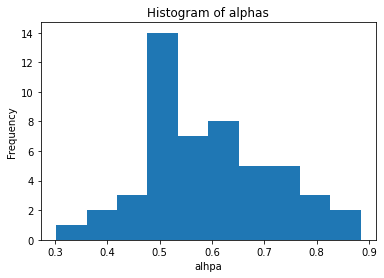

In [114]:
# Plot histogram
plt.hist(alphas)
plt.title('Histogram of alphas')
plt.xlabel('alhpa')
plt.ylabel('Frequency')
plt.show()

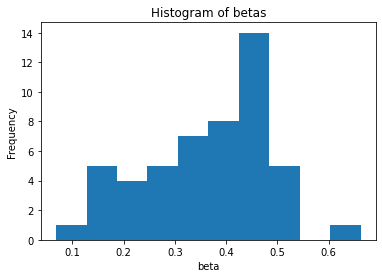

In [115]:
# Plot histogram
plt.hist(betas)
plt.title('Histogram of betas')
plt.xlabel('beta')
plt.ylabel('Frequency')
plt.show()

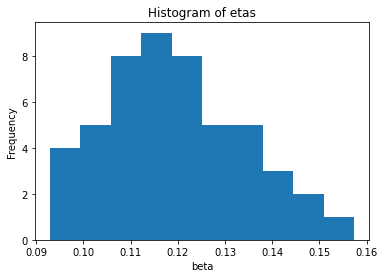

In [116]:
# Plot histogram
plt.hist(etas)
plt.title('Histogram of etas')
plt.xlabel('beta')
plt.ylabel('Frequency')
plt.show()

### Simulate DGP

In [128]:
def simulate_blundell_bond(Y,alphas, betas, etas, residuals):
    Y_bb = np.copy(Y)
    for i in range(Y.shape[1]-2):
        Y_bb[:,i+2] = Y_bb[:,i+1]*alphas + Y_bb[:,i]*betas + etas + np.random.choice(residuals, size=Y.shape[0], replace=True)
    W = np.zeros(Y.shape)
    treated_units = np.random.choice(50, size=10, replace=False)
    W[treated_units,-10:] = 1
    return Y_bb, W, treated_units

### AR2 Estimator

In [134]:
def AR2_estimator(Y,W,treated_units,treated_periods=10):
    T = Y.shape[1]
    predicted_outcomes = 0
    for i in treated_units:
        alpha = cp.Variable()
        beta = cp.Variable()
        eta = cp.Variable()

        Y_ts = Y[i, 2:-treated_periods]
        Y_lag_1 = Y[i, 1:-treated_periods-1]
        Y_lag_2 = Y[i,:-treated_periods-2]

        objective = cp.sum_squares(Y_ts-alpha*Y_lag_1-beta*Y_lag_2-eta)

        constraints = []

        prob = cp.Problem(cp.Minimize(objective),
                          constraints)
        prob.solve()
        
        Y_predict = np.zeros((treated_periods+2,))
        
        Y_predict[0] = Y[i, -treated_periods-2]
        Y_predict[1] = Y[i, -treated_periods-1]
        
        for t in range(treated_periods):
            Y_predict[t+2] = Y_predict[t]*beta.value + Y_predict[t+1]*alpha.value + eta.value
        
        predicted_outcomes += np.sum(Y_predict[2:])
        
        #print(Y_predict)
        
    return np.mean(Y[treated_units,-treated_periods:])-predicted_outcomes/(treated_periods*treated_units.shape[0])

### Run simulations

In [135]:
errors_sdid = []
errors_dwcp = []
errors_mc = []
errors_sc = []
errors_difp = []
errors_did = []
errors_ar2 = []

for experiment in range(500):
        
    np.random.seed(experiment)

    #Y_true, W_true, treated_units = generate_data(F, M, cov_mat, pi)
    Y_true, W_true, treated_units = simulate_blundell_bond(Y_true_full, alphas, betas, etas, residuals)

    print('experiment', experiment, 'treated units', treated_units)
        
    # DID 
    estimate = DID_TWFE(Y_true,W_true)                                               
    errors_did.append(estimate)
    
    # SC
    estimate = SC_TWFE(Y_true,W_true,treated_units,treated_periods=10)
    errors_sc.append(estimate)
    
    # DIFP
    estimate = DIFP_TWFE(Y_true,W_true,treated_units,treated_periods=10)
    errors_difp.append(estimate)
    
    # MC
#     L=run_MCNNM(np.multiply(Y_true,1-W_true),np.argwhere(1-W_true), lambd=0.8, threshold = 1e-5, print_every= None, max_iters = 20000)
#     errors_mc.append(np.mean(Y_true[treated_units,-10:]-L[treated_units,-10:]))

    estimate = DWCP_TWFE_average(Y_true,W_true,treated_units,lambda_unit=0,lambda_time=0,lambda_nn=0.6)
    errors_mc.append(estimate)

    # SDID
    estimate = SDID_TWFE(Y_true, W_true, treated_units,treated_periods=10)
    errors_sdid.append(estimate)

    # DWCP
    estimate = DWCP_TWFE_average(Y_true,W_true,treated_units,lambda_unit=1.0,lambda_time=0.5,lambda_nn=0.001,treated_periods=10)
    errors_dwcp.append(estimate)
    print(estimate)

    # AR2
    estimate = AR2_estimator(Y_true,W_true,treated_units,treated_periods=10)
    errors_ar2.append(estimate)

experiment 0 treated units [16 41 20 10 42  5 34  9 31 49]
0.0317144415970995
experiment 1 treated units [37 12  5 23  1  9 38 47  2 43]
0.0017733693789144264
experiment 2 treated units [35 47 17 34 15 13  8 20 43  0]
0.029052649493551956
experiment 3 treated units [24 13 10 25 49 22 20 46 36  9]
0.029756550279044464
experiment 4 treated units [17 16 44 42 29 19 30 39  3 37]
-0.008012476636394088
experiment 5 treated units [27 34 18 22 12 16 28  6 33 48]
0.040185784930387373
experiment 6 treated units [29 45 33 36 42 30  9 11 38 14]
0.005884980574369047
experiment 7 treated units [32 46 17 15 34  4 12 43 37 33]
-0.008304961724624615
experiment 8 treated units [25 34 17  5 46  4 48 39  1 18]
-0.044486278054218426
experiment 9 treated units [47  0  7 36  4 28 32  9  6 40]
0.053179358146630044
experiment 10 treated units [17 31 46 29 28 15 35 40 32 24]
-0.027429052264512043
experiment 11 treated units [21 19 34 24 40 35 41 18 11 20]
0.04620086638162831
experiment 12 treated units [30 49 4

In [140]:
print('SDID: ', np.sqrt(np.mean(np.square(errors_sdid))),'DWCP: ',
      np.sqrt(np.mean(np.square(errors_dwcp))), 'MC: ', np.sqrt(np.mean(np.square(errors_mc))),
      '|SC: ', np.sqrt(np.mean(np.square(errors_sc))), 'DID: ', np.sqrt(np.mean(np.square(errors_did))),
      'DIFP: ', np.sqrt(np.mean(np.square(errors_difp))))

SDID:  0.05960839473308863 DWCP:  0.044162101807827495 MC:  0.0580607935217512 |SC:  0.06981734578825045 DID:  0.08872927872642565 DIFP:  0.07088494443978482


In [141]:
print('SDID: ', (np.mean((errors_sdid))),'DWCP: ',
      (np.mean((errors_dwcp))), 'MC: ', (np.mean((errors_mc))),
      '|SC: ', (np.mean((errors_sc))), 'DID: ', (np.mean((errors_did))),
      'DIFP: ', (np.mean((errors_difp))))

SDID:  0.0018150032319698302 DWCP:  0.0019110896048791762 MC:  -6.677949997166877e-05 |SC:  0.0003571921517688792 DID:  -0.0033881578502007754 DIFP:  0.0004286488388455334


In [138]:
print(np.sqrt(np.mean(np.square(errors_ar2))))

0.06789556697016932


In [139]:
np.mean((errors_ar2))

0.01573086821801216

# Optimal Tuning Parameter

In [83]:
np.array([0.045,0.086,0.070,0.092,0.049,0.071,0.038])/0.038

array([1.18421053, 2.26315789, 1.84210526, 2.42105263, 1.28947368,
       1.86842105, 1.        ])

In [917]:
np.random.seed(0)
Y_true, W_true, treated_units = generate_data(F, M, cov_mat, pi)

In [837]:
treated_units

array([6])

## Select lambda_unit

In [267]:
treated_periods = 10
treated_unit_number = 10

In [268]:
def get_ATE(trial, Y_true, lambda_unit, lambda_time, lambda_nn):
    np.random.seed(trial)
    test_units = np.random.choice(np.arange(N_total), size=treated_unit_number,replace=False)
    W_test = np.zeros(Y_true.shape)
    W_test[test_units,-treated_periods:] = 1
    estimate = DWCP_TWFE_average(Y_true,W_test, test_units,lambda_unit=lambda_unit,lambda_time=lambda_time,lambda_nn=lambda_nn)
    return estimate

In [304]:
def get_ATE(trial, Y_true, lambda_unit, lambda_time, lambda_nn):
    np.random.seed(trial)
    #_, W_test, test_units = generate_data(F, M, cov_mat, pi)
    _, W_test, test_units = simulate_blundell_bond(Y_true_full, alphas, betas, etas, residuals)
    estimate = DWCP_TWFE_average(Y_true,W_test, test_units,lambda_unit=lambda_unit,lambda_time=lambda_time,lambda_nn=lambda_nn)
    return estimate

In [348]:
Q = []
lambda_units = np.arange(0,3,3/10)
for lambda_unit in lambda_units:
    lambda_time = 0.04
    lambda_nn = 0.151
    print(lambda_unit,lambda_time,lambda_nn)
    ATEs = Parallel(n_jobs=36, prefer='processes')(
                 delayed(get_ATE)(trial,Y_true,lambda_unit=lambda_unit,lambda_time=lambda_time,lambda_nn=lambda_nn)
                 for trial in range(100))
    Q.append(np.sqrt(np.mean(np.square(ATEs))))
    print(np.sqrt(np.mean(np.square(ATEs))))

0.0 0.04 0.151
0.04588363717133153
0.3 0.04 0.151
0.04572646196172048
0.6 0.04 0.151
0.04575199693876296
0.8999999999999999 0.04 0.151
0.04621572247428329
1.2 0.04 0.151
0.04672871338788681
1.5 0.04 0.151
0.04753617359722321
1.7999999999999998 0.04 0.151
0.0485428024030767
2.1 0.04 0.151
0.04955740167392886
2.4 0.04 0.151
0.05067234248103754
2.6999999999999997 0.04 0.151
0.051904804515413724


In [349]:
lambda_units[np.argmin(Q)]

0.3

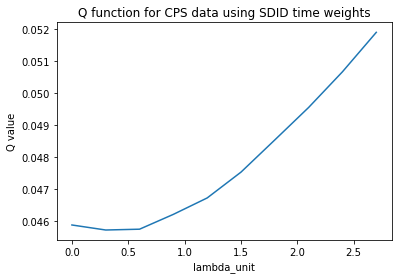

In [350]:
plt.plot(lambda_units,Q)
plt.xlabel('lambda_unit')
plt.ylabel('Q value')
plt.title('Q function for CPS data using SDID time weights')
plt.show()

## Select lambda_time

In [337]:
Q = []
lambda_times = np.arange(0,0.2,0.2/10)
for lambda_time in lambda_times:
    lambda_nn = 0.151
    lambda_unit = 0.3
    print(lambda_unit,lambda_time,lambda_nn)
    ATEs = Parallel(n_jobs=36, prefer='processes')(
                 delayed(get_ATE)(trial,Y_true,lambda_unit=lambda_unit,lambda_time=lambda_time,lambda_nn=lambda_nn)
                 for trial in range(100))
    Q.append(np.sqrt(np.mean(np.square(ATEs))))
    print(np.sqrt(np.mean(np.square(ATEs))))

0.3 0.0 0.151
0.04733931807582626
0.3 0.02 0.151
0.04696097857201654
0.3 0.04 0.151
0.04572646196172048
0.3 0.06 0.151
0.04718223543616423
0.3 0.08 0.151
0.04702813237410054
0.3 0.1 0.151
0.04677351506013778
0.3 0.12 0.151
0.04756926399168531
0.3 0.14 0.151
0.04706951415558455
0.3 0.16 0.151
0.048581005555868036
0.3 0.18 0.151
0.04904058291986118


In [338]:
lambda_times[np.argmin(Q)]

0.04

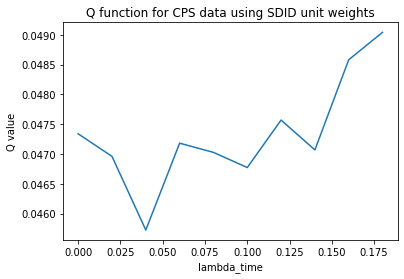

In [339]:
plt.plot(lambda_times,Q)
plt.xlabel('lambda_time')
plt.ylabel('Q value')
plt.title('Q function for CPS data using SDID unit weights')
plt.show()

### Select lambad_nn

In [340]:
Q = []
lambda_nns = np.arange(0.001,0.5,0.501/10)
for lambda_nn in lambda_nns:
    lambda_time = 0.04
    lambda_unit = 0.3
    print(lambda_unit,lambda_time,lambda_nn)
    ATEs = Parallel(n_jobs=36, prefer='processes')(
                 delayed(get_ATE)(trial,Y_true,lambda_unit=lambda_unit,lambda_time=lambda_time,lambda_nn=lambda_nn)
                 for trial in range(100))
    Q.append(np.sqrt(np.mean(np.square(ATEs))))
    print(np.sqrt(np.mean(np.square(ATEs))))

0.3 0.04 0.001
0.05875111230401435
0.3 0.04 0.0511
0.047002575287222
0.3 0.04 0.1012
0.04592367474906946
0.3 0.04 0.1513
0.045723923409727016
0.3 0.04 0.2014
0.04585499541106874
0.3 0.04 0.2515
0.04638353008604837
0.3 0.04 0.3016
0.046769989679083614
0.3 0.04 0.3517
0.04716080630740976
0.3 0.04 0.4018
0.04731951367366882
0.3 0.04 0.45189999999999997
0.0473807461240015


In [341]:
lambda_nns[np.argmin(Q)]

0.1513

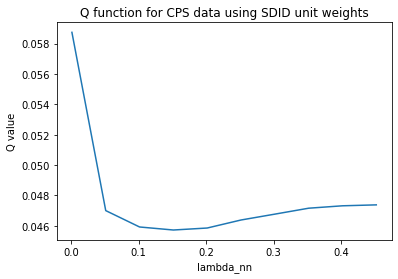

In [342]:
plt.plot(lambda_nns,Q)
plt.xlabel('lambda_nn')
plt.ylabel('Q value')
plt.title('Q function for CPS data using SDID unit weights')
plt.show()

In [343]:
Q

[0.05875111230401435,
 0.047002575287222,
 0.04592367474906946,
 0.045723923409727016,
 0.04585499541106874,
 0.04638353008604837,
 0.046769989679083614,
 0.04716080630740976,
 0.04731951367366882,
 0.0473807461240015]